In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


This image is: <class 'numpy.ndarray'> with dimension: (540, 960, 3)


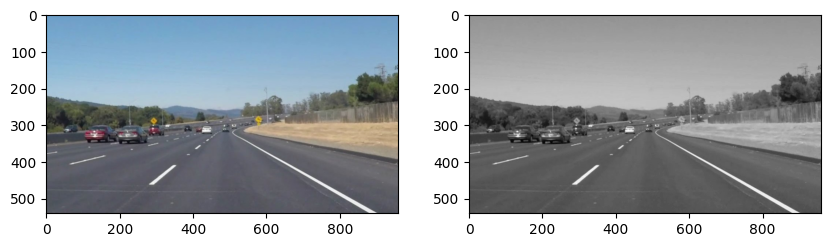

In [2]:
image = cv2.imread('/home/veeransh/Desktop/self-driven-car-ai/Data/straight_line.png')
print('This image is:', type(image), 'with dimension:', image.shape)
plt.figure(figsize = (10, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), cmap = 'gray')
plt.show()


In [3]:
import math

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255   
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def select_rgb_white_yellow(image): 
    # white color mask
    lower = np.uint8([200, 200, 200])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.uint8([190, 190,   0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

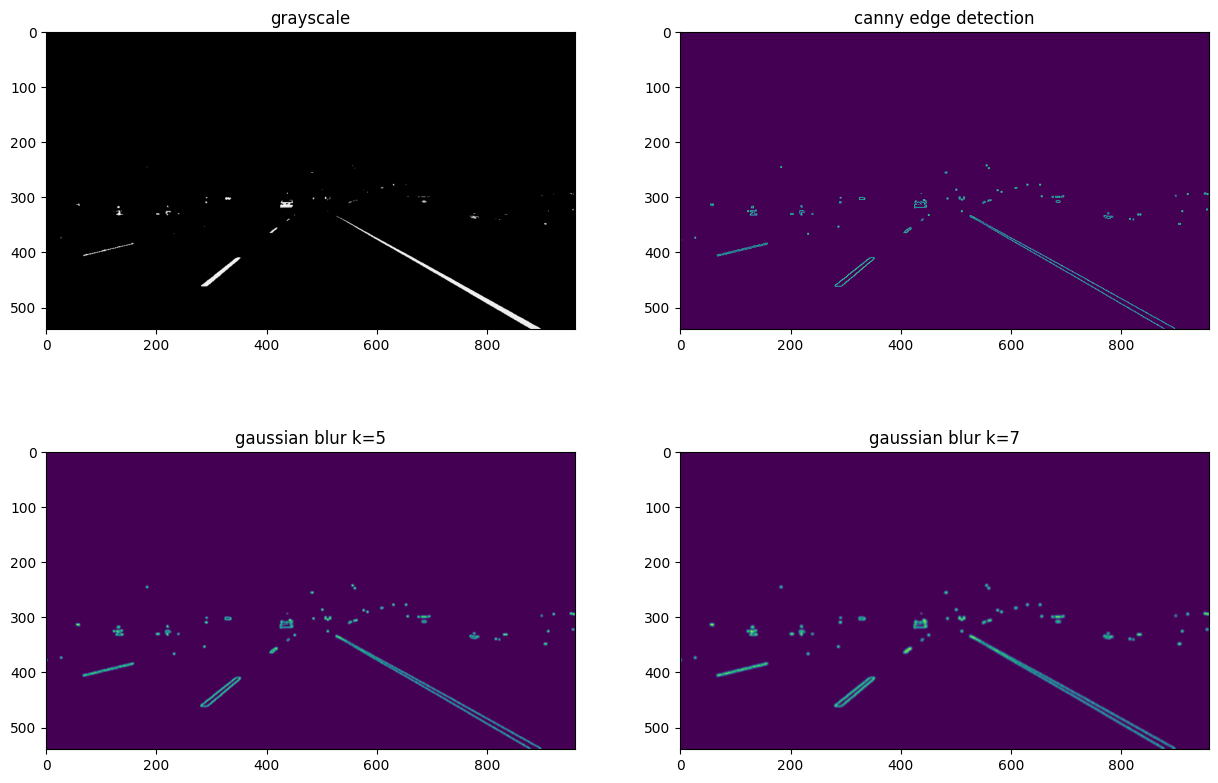

In [4]:
plt.figure(figsize = (15, 10))

filtered_color = select_rgb_white_yellow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(2, 2, 1)
plt.imshow(grayscale(filtered_color), cmap = 'gray')
plt.title('grayscale')

plt.subplot(2, 2, 2)
plt.imshow(canny(filtered_color, 100, 150))
plt.title('canny edge detection')

plt.subplot(2, 2, 3)
plt.imshow(gaussian_blur(canny(filtered_color, 100, 150), 5))
plt.title('gaussian blur k=5')

plt.subplot(2, 2, 4)
plt.imshow(gaussian_blur(canny(filtered_color, 100, 150), 7))
plt.title('gaussian blur k=7')

plt.show()

In [5]:
blurred = gaussian_blur(canny(filtered_color, 100, 150), 7)
rows, cols = image.shape[:2]
bottom_left  = [int(cols*-0.35), int(rows*0.95)]
top_left     = [int(cols*0.15), int(rows*0.65)]
bottom_right = [int(cols*0.95), int(rows*0.95)]
top_right    = [int(cols*0.65), int(rows*0.65)]
vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)

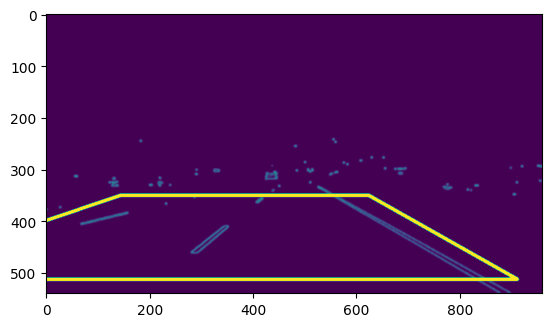

In [6]:
copied = np.copy(blurred)
cv2.line(copied,tuple(bottom_left),tuple(bottom_right), (255, 0, 0), 5)
cv2.line(copied,tuple(bottom_right),tuple(top_right), (255, 0, 0), 5)
cv2.line(copied,tuple(top_left),tuple(bottom_left), (255, 0, 0), 5)
cv2.line(copied,tuple(top_left),tuple(top_right), (255, 0, 0), 5)
plt.imshow(copied)
plt.show()

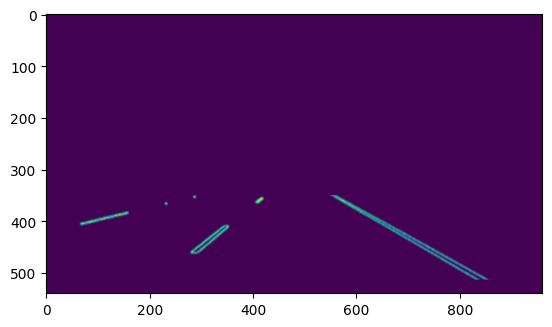

In [7]:
copied = np.copy(blurred)
plt.imshow(region_of_interest(copied,vertices))
plt.show()

In [8]:
from sklearn.cluster import AgglomerativeClustering
interested = region_of_interest(copied,vertices)
wheres = np.where(interested > 80)
clustered = AgglomerativeClustering(3).fit_predict(wheres[1].reshape([-1,1]))

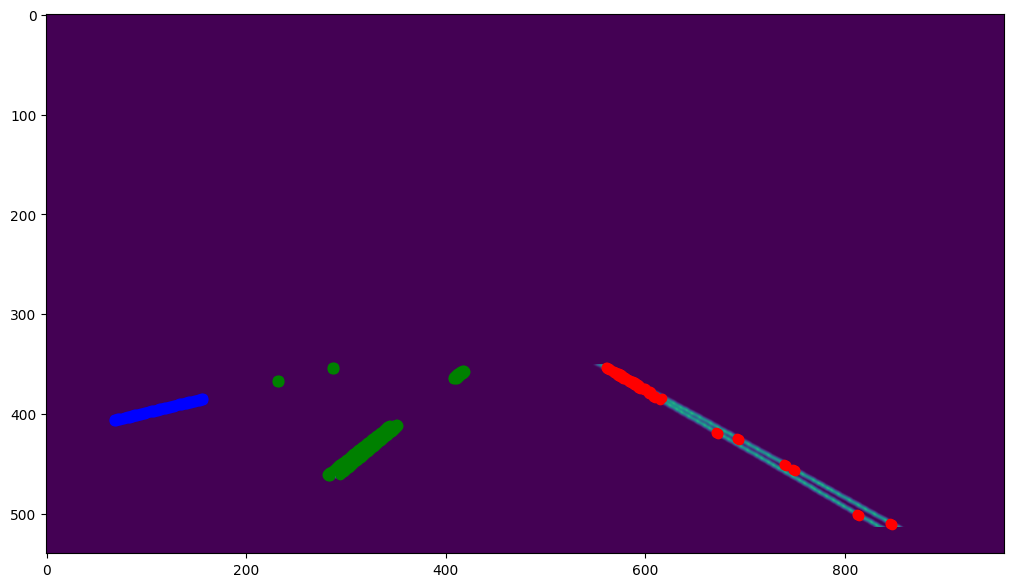

In [9]:
plt.figure(figsize = (15, 7))
plt.imshow(interested)
colors = ['r','g','b']
for i in range(3):
    plt.scatter(wheres[1][clustered==i],wheres[0][clustered==i],label=i,color=colors[i])
plt.show()
plt.show()

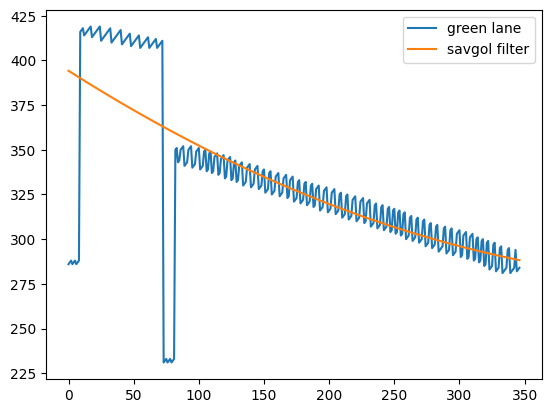

In [10]:
from scipy import signal
plt.plot(wheres[1][clustered==1],label='green lane')
savgol = signal.savgol_filter(wheres[1][clustered==1], wheres[1][clustered==1].shape[0], 2)
plt.plot(savgol,label='savgol filter')
plt.legend()
plt.show()

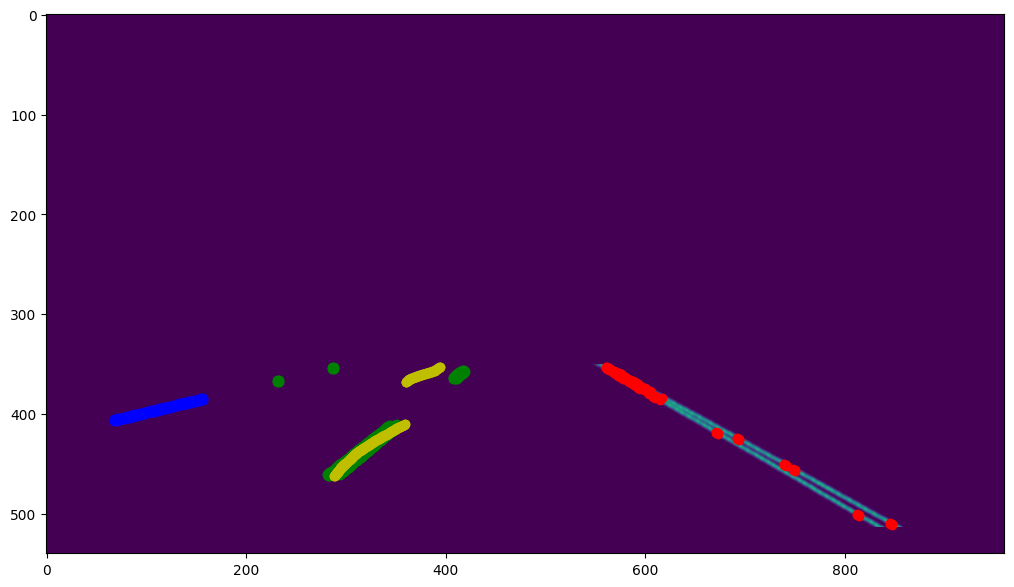

In [11]:
plt.figure(figsize = (15, 7))
plt.imshow(interested)
colors = ['r','g','b']
for i in range(3):
    plt.scatter(wheres[1][clustered==i],wheres[0][clustered==i],label=i,color=colors[i])
plt.scatter(savgol,wheres[0][clustered==1],color='y')
plt.show()
plt.show()

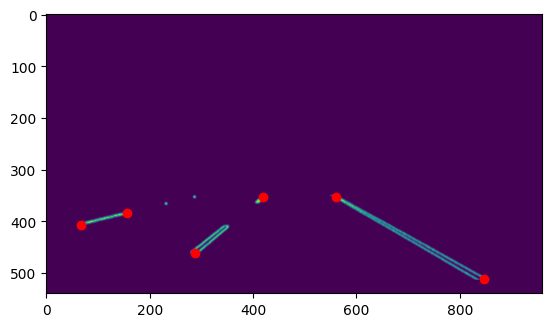

In [12]:
blue_x, blue_y = wheres[1][clustered==2], wheres[0][clustered==2]
blue_top = [np.max(blue_x),np.min(blue_y)]
blue_bottom = [np.min(blue_x),np.max(blue_y)]

green_x, green_y = wheres[1][clustered==1], wheres[0][clustered==1]
green_top = [np.max(green_x),np.min(green_y)]
green_bottom = [np.min(savgol),np.max(green_y)]

red_x, red_y = wheres[1][clustered==0], wheres[0][clustered==0]
red_top = [np.min(red_x),np.min(red_y)]
red_bottom = [np.max(red_x),np.max(red_y)]

plt.imshow(interested)

plt.scatter(*blue_top,c='r')
plt.scatter(*blue_bottom,c='r')

plt.scatter(*green_top,c='r')
plt.scatter(*green_bottom,c='r')

plt.scatter(*red_top,c='r')
plt.scatter(*red_bottom,c='r')

plt.show()

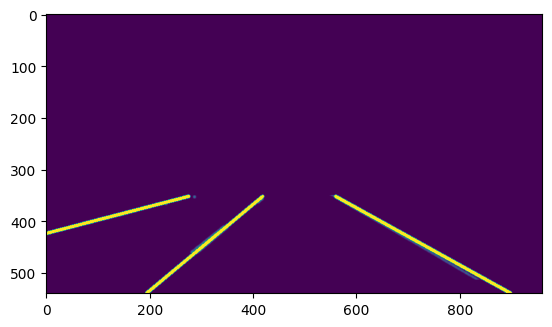

In [13]:
m_blue, c_blue = np.polyfit([blue_top[1],blue_bottom[1]],
                           [blue_top[0],blue_bottom[0]],1)
dot_blue_bottom = [int(image.shape[0]*m_blue+c_blue),image.shape[0]]
dot_blue_top = [int(green_top[1]*m_blue+c_blue),green_top[1]]
copied = np.copy(interested)
cv2.line(copied,tuple(dot_blue_top),tuple(dot_blue_bottom),(255,0,0),5)

m_green, c_green = np.polyfit([green_top[1],green_bottom[1]],
                           [green_top[0],green_bottom[0]],1)
dot_green_bottom = [int(image.shape[0]*m_green+c_green),image.shape[0]]
cv2.line(copied,tuple(green_top),tuple(dot_green_bottom),(255,0,0),5)

m_red, c_red = np.polyfit([red_top[1],red_bottom[1]],
                           [red_top[0],red_bottom[0]],1)
dot_red_bottom = [int(image.shape[0]*m_red+c_red),image.shape[0]]
cv2.line(copied,tuple(red_top),tuple(dot_red_bottom),(255,0,0),5)

plt.imshow(copied)
plt.show()

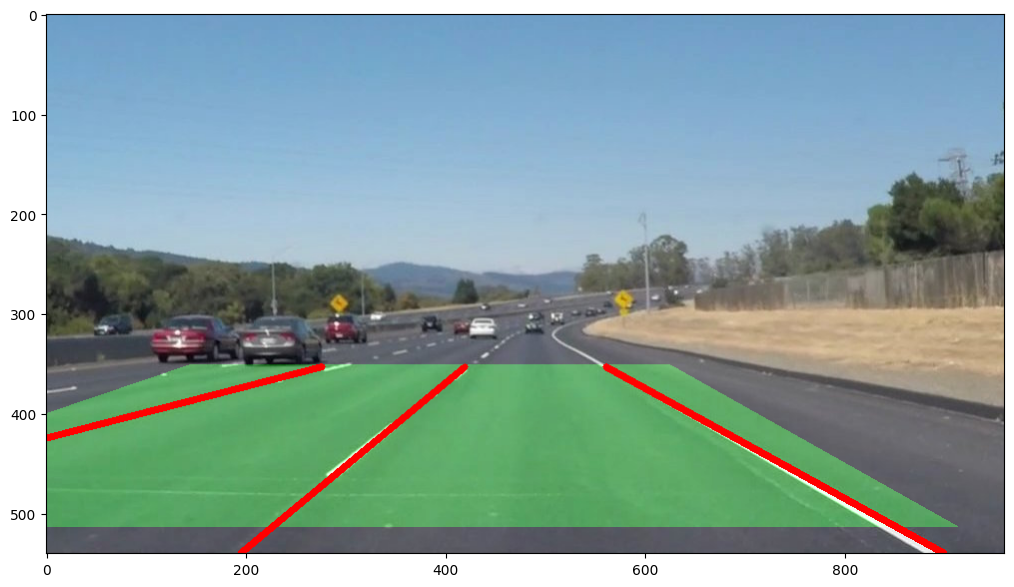

In [14]:
plt.figure(figsize = (15, 7))
copied = np.copy(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
window_img = np.zeros_like(copied)    
polyfill = np.array([bottom_left,bottom_right,top_right,top_left])
cv2.fillPoly(window_img, pts =[polyfill], color=(0,255, 0))
copied = cv2.addWeighted(copied, 1, window_img, 0.3, 0)
cv2.line(copied,tuple(dot_blue_top),tuple(dot_blue_bottom),(255,0,0),5)
cv2.line(copied,tuple(green_top),tuple(dot_green_bottom),(255,0,0),5)
cv2.line(copied,tuple(red_top),tuple(dot_red_bottom),(255,0,0),5)
plt.imshow(copied)
plt.show()